In [34]:
from gymnasium.wrappers import TimeLimit
from env_hiv import HIVPatient

In [35]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import copy

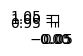

In [36]:
plt.figure(1,(0.1,0.1))
plt.plot(1)

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from tqdm import trange

In [38]:
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = int(capacity) # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled
        self.device = device

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(np.array(x)).to(self.device), list(zip(*batch))))
    
    def __len__(self):
        return len(self.data)

In [39]:
from copy import deepcopy
import torch.nn as nn
import torch
import numpy as np
from evaluate import evaluate_HIV

class Agent:
    def __init__(self,config,DQN):
        self.config = config

        self.config['epsilon_step'] =(self.config['epsilon_max']-self.config['epsilon_min'])/self.config['epsilon_decay_period']
        self.dqn = DQN
        self.target_dqn = deepcopy(self.dqn)
        self.replay_buffer = ReplayBuffer(self.config['buffer_size'], self.config['device'])
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=self.config['learning_rate'])

    def sample_action_greedy(self, s):
        with torch.no_grad():
            s = torch.tensor(s, device=self.config['device'], dtype=torch.float32)
            self.dqn.eval()
            Q = self.dqn(s)
            self.dqn.train()
        return torch.argmax(Q).cpu().item()
    
    def sample_action_eps_greedy(self, env, s, eps):
        e = np.random.sample()
        if e>eps:
            return self.sample_action_greedy(s[None, :]), 0
        return env.action_space.sample(), 1
    
    def update_target(self, step):
        if self.config['update_replace'] and step % self.config['update_target_replace'] == 0:
            self.target_dqn = deepcopy(self.dqn)
            print("Update Target")
        else:
            target_state_dict = self.target_dqn.state_dict()
            model_state_dict = self.dqn.state_dict()
            tau = self.config["update_target_tau"]
            for key in model_state_dict:
                target_state_dict[key] = tau*model_state_dict[key] + (1-tau)*target_state_dict[key]
            self.target_dqn.load_state_dict(target_state_dict)

    def act(self, observation, use_random=False):
        return self.sample_action_greedy(observation[None, :])

    def save(self, path):
        torch.save({'model_state_dict': self.dqn.state_dict()}, path)

    def load(self):
        self.config['device'] = 'cpu'
        base_path = "dqn_final.pth"
        chkpt = torch.load(base_path, map_location=torch.device('cpu'))
        self.dqn.load_state_dict(chkpt['model_state_dict'])
        self.dqn.to(self.config['device'])
        self.dqn.eval()
        self.target_dqn =  deepcopy(self.dqn).to(self.config['device'])

    def gradient_step(self):
        if len(self.replay_buffer) >= self.config['batch_size']:
            
            samples = self.replay_buffer.sample(self.config['batch_size'])
            s, a, r, sp, d = samples
            QYmax = self.target_dqn(sp).max(1)[0].detach()
            
            update = torch.addcmul(r, 1-d, QYmax, value=self.config["gamma"])
            
            s.requires_grad = True
            QXA = self.dqn(s).gather(1, a.to(torch.long).unsqueeze(1))
            
            loss = self.criterion(QXA, update.unsqueeze(1))
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
            return loss.detach()
        return 0 
    
    def train(self, env):

        # Log Lists
        episode_return = []
        episode_grad = []
        episode_loss = []
        episode_actions = []
        track_actions = [0, 0, 0, 0]

        # env + network
        self.dqn.to(self.config['device'])
        self.dqn.train()
        self.target_dqn.to(self.config['device'])
        s, _ = env.reset()

        # Init variables
        cum_reward= 0
        epsilon = self.config['epsilon_max']
        random_actions = 0
        losses = 0
        best_score = 0

        # Main loop
        for step in range(self.config['training_steps']):
            try:
                # Print Infos
                if step%17 == 0:
                    print("Step :",step,
                        "| Episode :",step//self.config['ep_length'],
                        "| Grad :",'{:1.7f}'.format(self.mean_grad()),
                        end="\r")
                
                # Choose action
                if step > self.config['epsilon_delay_decay']:
                    epsilon = max(self.config['epsilon_min'], epsilon-self.config['epsilon_step'])
                a, rand_action = self.sample_action_eps_greedy(env, s, epsilon)
                random_actions += rand_action
                sp, r, d, t, _ = env.step(a)
                r = r/1000000
                cum_reward+=r
                track_actions[a] += 1

                # Buffer
                self.replay_buffer.append(s, a, r, sp, d)

                # Gradient step
                for _ in range(self.config['gradient_steps']):
                    losses += self.gradient_step()

                # Update target
                self.update_target(step)
                
                # Save Model
                if step % self.config['save_delay'] == 0:
                    self.save(f'model_dir/dqn_{step}.pth')

                if step % self.config['ep_length'] == 0:
                    
                    # Epoch Print
                    val_score = evaluate_HIV(agent = self, nb_episode=1)
                    print(f'step {step+1}',
                        f' | Score: {"{:e}".format(val_score)}',
                        f' | rolling reward: {cum_reward}',
                        f' | random actions: {random_actions}',
                        f' | loss: {"{:e}".format(losses/200)}',
                        f' | epsilon {"{:6.2f}".format(epsilon)}')
                    
                    # Save Best
                    if val_score > best_score:
                        self.save(f'model_dir/dqn_best.pth')
                        best_score = val_score
                    
                    episode_return.append(val_score)
                    episode_grad.append(self.mean_grad())
                    episode_loss.append(losses/self.config['ep_length'])
                    episode_actions.append(track_actions)
                    
                    # Resets
                    track_actions = [0, 0, 0, 0]
                    random_actions = 0
                    losses = 0
                    cum_reward= 0
                    s, _ = env.reset()
                else:
                    s = sp
            #except Exception as e:
            #    raise
            except:
                return episode_return, episode_grad, episode_loss, episode_actions
            
        print(f"Total reward {cum_reward}")
        return episode_return, episode_grad, episode_loss, episode_actions
        
    def mean_grad(self):
        try:
            gradients = []
            for param in self.model.parameters():
                if param.grad is not None:
                    gradients.append(param.grad.view(-1))
            gradients = torch.cat(gradients)
            mean_grad = gradients.mean()
            
            return mean_grad.item()
        except:
            return 0
    
    def show_run(self, env, force_path=None):
        # Initialize environment
        state, _ = env.reset()
        actions, states, rewards = [], [state], []
        if force_path is None:
            self.model.load_state_dict(torch.load(os.path.join("model_dir", "dqn_best.pth")))
        else:
            self.model.load_state_dict(torch.load(os.path.join("model_dir", force_path)))
        
        while True:
            # Select the best action for the current state
            action = self.act(state)
            actions.append(action)
            
            # Execute the selected action
            state, reward, done, trunc, _ = env.step(action)
            states.append(state)
            rewards.append(reward)
            
            # Break if the episode is done
            if trunc:
                break
        
        print("Total reward", sum(rewards))
        # Plotting
        fig, axs = plt.subplots(3, 1, figsize=(10, 10))
        
        # Plot states
        states = np.array(states)
        for i in range(states.shape[1]):
            axs[0].plot(states[:, i], label=f"State {i+1}")
        axs[0].set_title("States over Time")
        axs[0].legend()
        
        # Plot actions
        axs[1].plot(actions, 'ro-', label="Action")
        axs[1].set_title("Actions over Time")
        axs[1].legend()
        
        # Plot rewards
        axs[2].plot(rewards, 'g^-', label="Reward")
        axs[2].set_title("Rewards over Time")
        axs[2].legend()
        
        plt.tight_layout()
        plt.show()

        return states

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeedQNetwork_Plus(nn.Module):
    def __init__(self, env, thresholds):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        width = 128

        # Calculate the number of additional features
        self.num_binary_vars = state_dim  # One binary variable per feature
        self.num_multiplications = int(state_dim * (state_dim - 1) / 2)  # Combination of pairs

        # Updated input dimension to account for the new features
        updated_input_dim = state_dim + self.num_binary_vars + self.num_multiplications

        self.bn1 = nn.BatchNorm1d(updated_input_dim)
        self.fc1 = nn.Linear(updated_input_dim, width)
        
        self.fc2 = nn.Linear(width, width)
        self.bn2 = nn.BatchNorm1d(width)
        self.fc3 = nn.Linear(width, action_dim)

        # Thresholds for creating binary variables
        self.thresholds = torch.tensor(thresholds, dtype=torch.float32)

    def forward(self, x):
        # Create binary variables
        binary_vars = (x < self.thresholds).float()

        # Calculate feature multiplications
        multiplications = []
        for i in range(x.size(1) - 1):
            for j in range(i + 1, x.size(1)):
                multiplications.append(x[:, i] * x[:, j])
        multiplications = torch.stack(multiplications, dim=1)

        # Concatenate original features, binary variables, and multiplications
        #print(x.shape,binary_vars.shape,multiplications.shape)
        x = torch.cat([x, binary_vars, multiplications], dim=1)

        # Forward pass
        x = self.bn1(x)
        x = self.fc1(x)
        x = F.gelu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.gelu(x)
        
        x = self.fc3(x)
        return x

def greedy_action(network, state):
    device = "cuda" if next(network.parameters()).is_cuda else "cpu"
    with torch.no_grad():
        network.eval()
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).item()

In [41]:
env = TimeLimit(
    env=HIVPatient(domain_randomization=True), max_episode_steps=200)

In [42]:
tresholds = [800000,500,1100,30,1000,20000]
DQN = DeedQNetwork_Plus(env,tresholds)

In [43]:
config = {
        "device": 'cpu',
        "training_steps": 40000,
        "ep_length": 200,
        "batch_size": 512,
        "learning_rate": 0.001,
        "gradient_steps": 3,
        "epsilon_min": 0.01,
        "epsilon_max": 1,
        "epsilon_decay_period": 20000,
        "epsilon_delay_decay": 500,
        "gamma": 0.85,
        "update_target_tau":0.001,
        "update_target_replace": 400,
        "update_replace": False,
        "buffer_size": 100000,
        "log_delay": 200,
        "save_delay": 1000
        }

# Train agent
agent = Agent(config, DQN)
episode_return, episode_grad, episode_loss, episode_actions = agent.train(env)

step 1  | Score: 1.512256e+07  | rolling reward: 0.007808100000000002  | random actions: 1  | loss: 0.000000e+00  | epsilon   1.00
step 201  | Score: 1.512256e+07  | rolling reward: 11.776552231984647  | random actions: 200  | loss: 0.000000e+00  | epsilon   1.00
step 401  | Score: 1.512256e+07  | rolling reward: 9.996572953385314  | random actions: 200  | loss: 0.000000e+00  | epsilon   1.00
step 601  | Score: 1.633757e+07  | rolling reward: 7.554093042439064  | random actions: 200  | loss: 1.474302e-02  | epsilon   1.00
step 801  | Score: 3.527137e+07  | rolling reward: 7.5080484985968665  | random actions: 195  | loss: 6.797418e-03  | epsilon   0.99
step 1001  | Score: 1.879189e+07  | rolling reward: 7.280500012821192  | random actions: 197  | loss: 6.505210e-03  | epsilon   0.98
step 1201  | Score: 2.703857e+07  | rolling reward: 9.68394575124155  | random actions: 193  | loss: 6.809204e-03  | epsilon   0.97
step 1401  | Score: 3.024926e+07  | rolling reward: 11.716784587777875  | 

C:\Users\adhem\AppData\Local\Temp\ipykernel_22896\3613436368.py:9: RuntimeWarning: divide by zero encountered in log10
  axes[2].plot(np.log10(episode_loss))


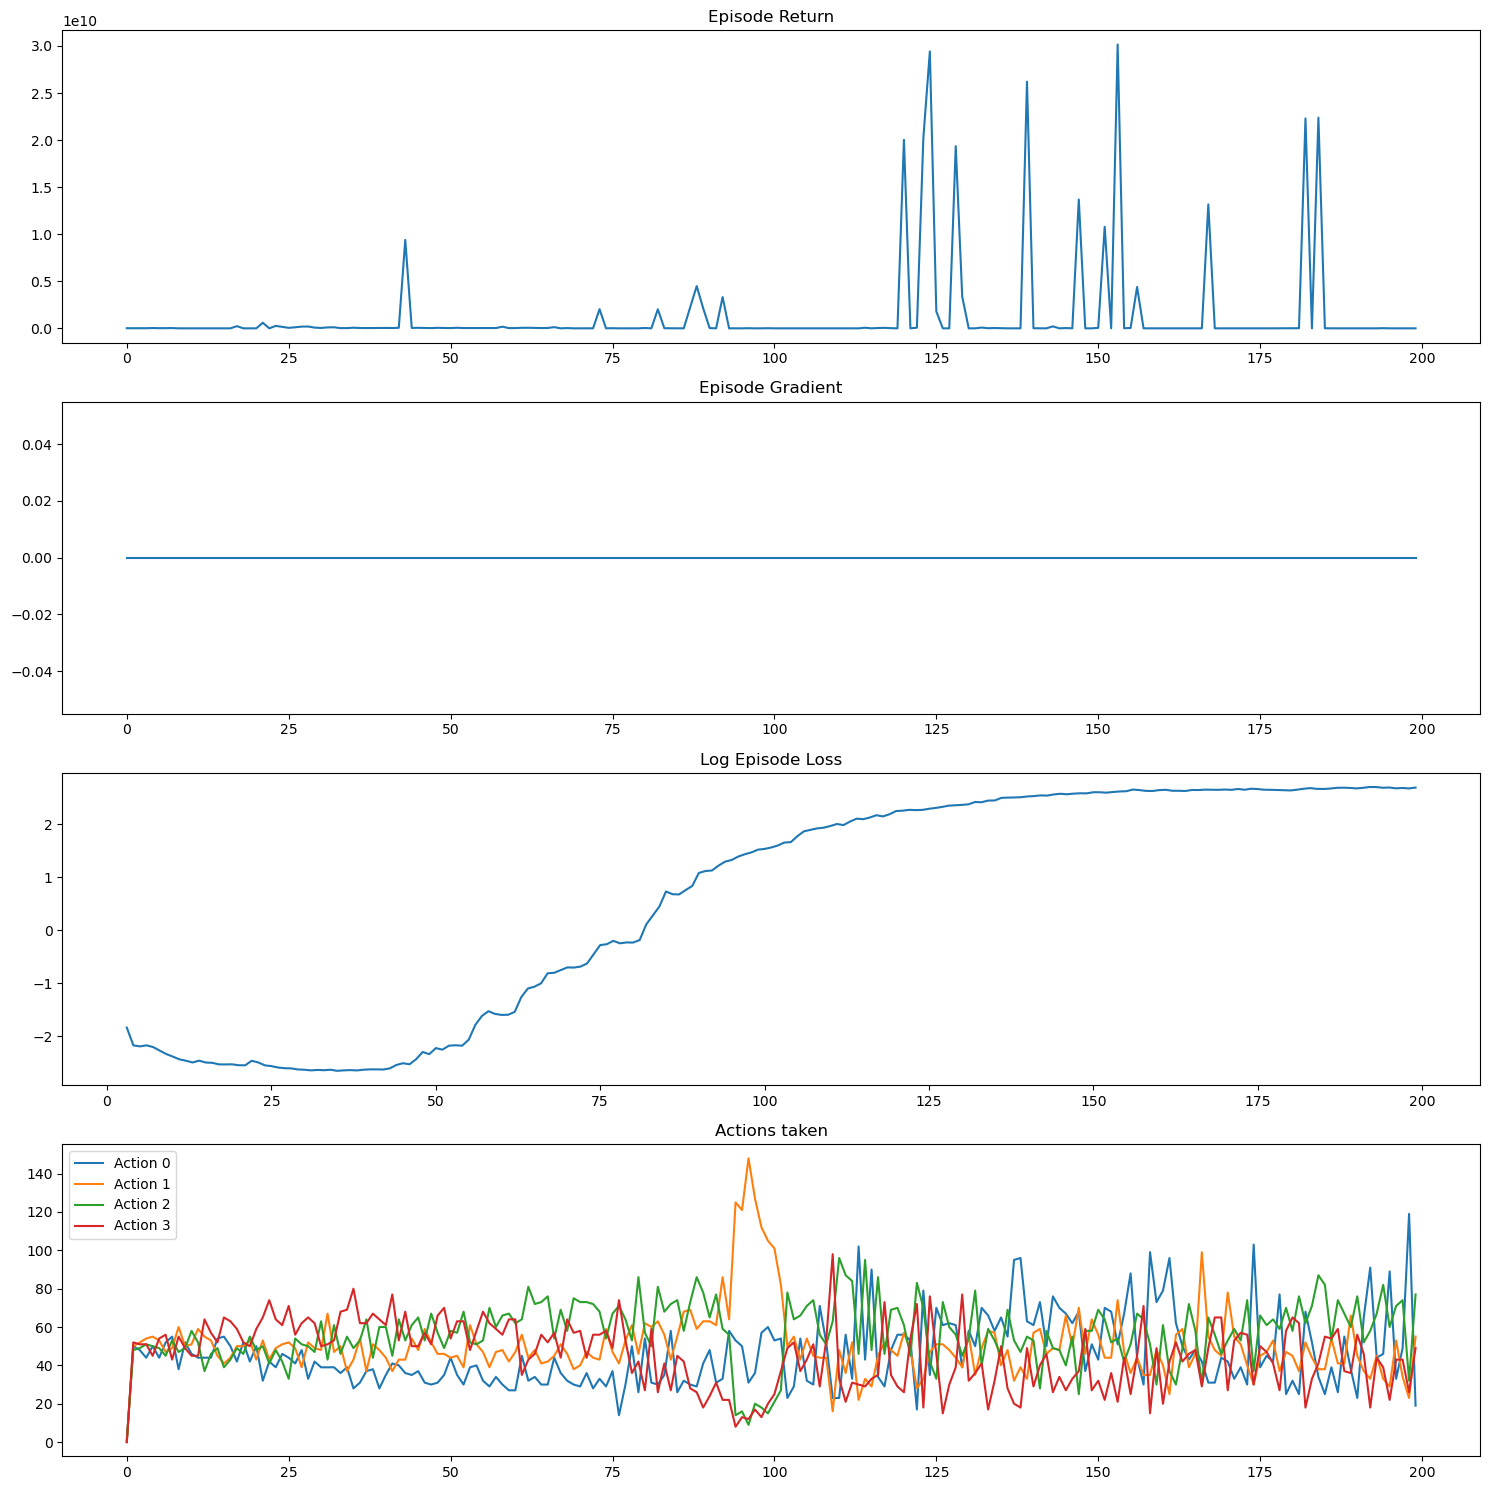

In [46]:
f, axes = plt.subplots(4, 1, figsize=(15, 15))  # Corrected line here

axes[0].plot(episode_return)
axes[0].set_title('Episode Return')

axes[1].plot(episode_grad)
axes[1].set_title('Episode Gradient')

axes[2].plot(np.log10(episode_loss))
axes[2].set_title('Log Episode Loss')

axes[3].plot(np.array(episode_actions)[:,0], label="Action 0")
axes[3].plot(np.array(episode_actions)[:,1], label="Action 1")
axes[3].plot(np.array(episode_actions)[:,2], label="Action 2")
axes[3].plot(np.array(episode_actions)[:,3], label="Action 3")
axes[3].set_title('Actions taken')
axes[3].legend()

plt.tight_layout()  # Optional: Improves the spacing between plots
plt.show()

In [47]:
states = agent.show_run(env)

AttributeError: 'Agent' object has no attribute 'model'

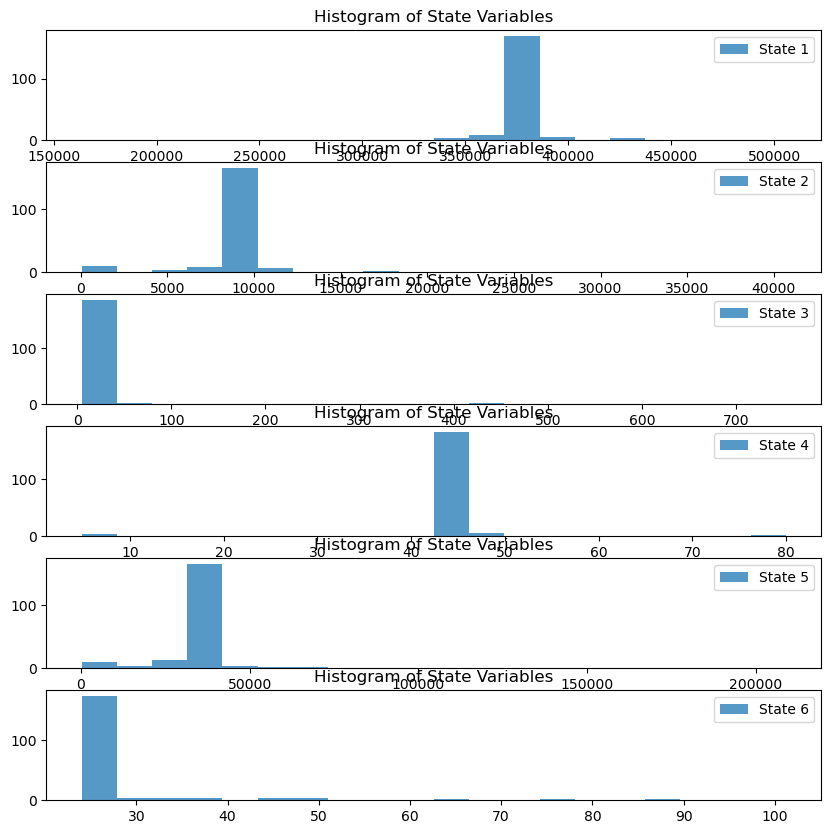

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(10, 10))

for i in range(states.shape[1]):
    axs[i].hist(states[:, i], bins=20, alpha=0.75, label=f"State {i+1}")
    axs[i].set_title("Histogram of State Variables")
    axs[i].legend()

In [ ]:
states[:, 0]

array([163573.        , 202147.57680694, 240892.91214946, 277894.41264717,
       313103.85915838, 346593.02576993, 378409.69854073, 408045.56129439,
       436482.86335519, 463783.98454415, 489143.56519849, 513463.02420718,
       536837.61110764, 559192.25705555, 578385.3882218 , 596471.55187721,
       615338.35292309, 633612.22439648, 651082.39561217, 667734.05185851,
       683565.45947412, 698576.04620429, 712755.98299628, 726076.97890674,
       739027.86480213, 751283.60371577, 763099.90400599, 774238.9420188 ,
       784487.31822898, 794427.43162488, 803618.90378127, 812549.36030841,
       820716.05537529, 828691.50659216, 836589.2524299 , 843825.48606506,
       850829.3648241 , 857096.39537452, 863221.5918359 , 869373.46322741,
       874882.27550616, 880258.05029802, 885654.03674681, 890490.7179796 ,
       895207.9950516 , 899320.74096375, 903436.95443276, 907714.2479206 ,
       911587.81583496, 915432.53948216, 918922.97100333, 922433.78527589,
       925667.87308269, 9

In [57]:
!python main.py

In [58]:

tresh_1 = [3432807.680391572, 1e8, 1e9, 1e10, 2e10, 5e10]
tresh_2 = [1e10, 2e10, 5e10]

score_file = "./score.txt"

with open(score_file) as f:
    lines = f.readlines()

score_1 = float(lines[0][:-2])
score_2 = float(lines[1])

print("Score 1",round(np.log10(score_1),3),round(score_1,3))
print("Score 2",round(np.log10(score_2),3),round(score_2,3))

def calculate_passed_thresholds(score, thresholds):
    return sum(score >= t for t in thresholds)

# Calculate surpassed thresholds for each score
passed_tresh_1 = calculate_passed_thresholds(score_1, tresh_1)
passed_tresh_2 = calculate_passed_thresholds(score_2, tresh_2)


total_score = passed_tresh_1 + passed_tresh_2  # Adjusted scoring logic

print()
print(str(total_score)+"/9",)
print()

passed_tresh_1, passed_tresh_2

Score 1 10.479 30152238674.901
Score 2 10.372 23576015644.557

7/9



(5, 2)